In [82]:
!pip install tldextract

In [83]:

import pandas as pd
import re
import tldextract
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [84]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sid321axn/malicious-urls-dataset -p /content/ --unzip

Dataset URL: https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset
License(s): CC0-1.0


In [85]:

def extract_features(url):
    ext = tldextract.extract(url)
    domain = ext.domain.lower()
    suffix = ext.suffix.lower()
    subdomain = ext.subdomain.lower()
    suspicious_keywords = ['login', 'verify', 'update', 'secure', 'account', 'paypal', 'bank', 'signin']

    legit_domains = ['google', 'microsoft', 'facebook', 'amazon', 'gmail', 'youtube', 'apple', 'linkedin']

    return {
        'url_length': len(url),
        'digit_count': sum(c.isdigit() for c in url),
        'special_char_count': len(re.findall(r'[^\w]', url)),
        'has_https': int(url.startswith("https")),
        'has_ip': int(bool(re.search(r'\d+\.\d+\.\d+\.\d+', url))),
        'count_dash': url.count('-'),
        'count_at': url.count('@'),
        'count_dot': url.count('.'),
        'suspicious_words': sum(1 for word in suspicious_keywords if word in url.lower()),
        'domain_length': len(domain),
        'subdomain_length': len(subdomain),
        'suffix_length': len(suffix),
        'is_legit_domain': int(domain in legit_domains),
        'is_suspicious_tld': int(suffix in ['xyz', 'ru', 'top', 'tk', 'gq', 'ml']),
        'keyword_in_domain': int(any(word in domain for word in suspicious_keywords)),
        'keyword_in_subdomain': int(any(word in subdomain for word in suspicious_keywords)),
        'hyphenated_domain': int('-' in domain or '-' in subdomain)
    }


In [86]:

df = pd.read_csv("/content/malicious_phish.csv")


X = pd.DataFrame(df['url'].apply(extract_features).tolist())


In [87]:

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['type'])  

In [90]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


X_train = X_train.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)


X_sample = X_train.sample(n=50000, random_state=42)
y_sample = y_train.loc[X_sample.index]

Random Forest Classification Report:
              precision    recall  f1-score   support

      benign       0.94      0.97      0.96     85621
  defacement       0.91      0.93      0.92     19292
     malware       0.97      0.86      0.91      6504
    phishing       0.86      0.76      0.81     18822

    accuracy                           0.93    130239
   macro avg       0.92      0.88      0.90    130239
weighted avg       0.93      0.93      0.93    130239



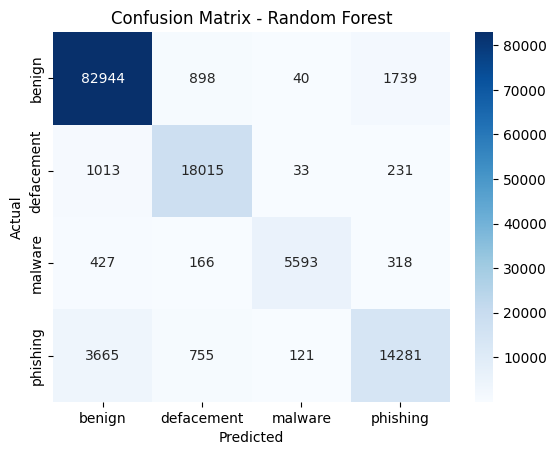

In [92]:


rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_sample, y_sample)

rf_preds = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds, target_names=label_encoder.classes_))

rf_cm = confusion_matrix(y_test, rf_preds)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:28:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

      benign       0.94      0.97      0.95     85621
  defacement       0.89      0.93      0.91     19292
     malware       0.95      0.85      0.90      6504
    phishing       0.86      0.75      0.80     18822

    accuracy                           0.92    130239
   macro avg       0.91      0.87      0.89    130239
weighted avg       0.92      0.92      0.92    130239



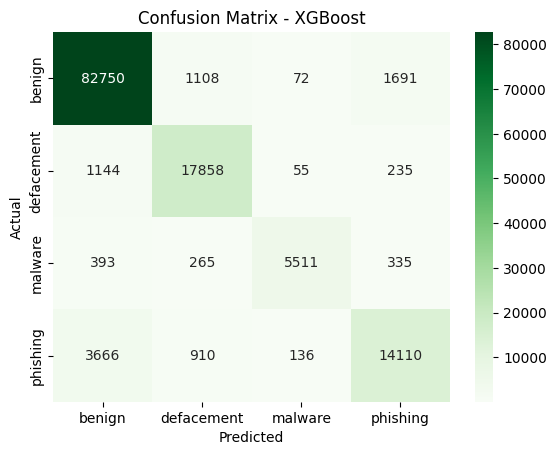

In [93]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_sample, y_sample)

xgb_preds = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds, target_names=label_encoder.classes_))


xgb_cm = confusion_matrix(y_test, xgb_preds)
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


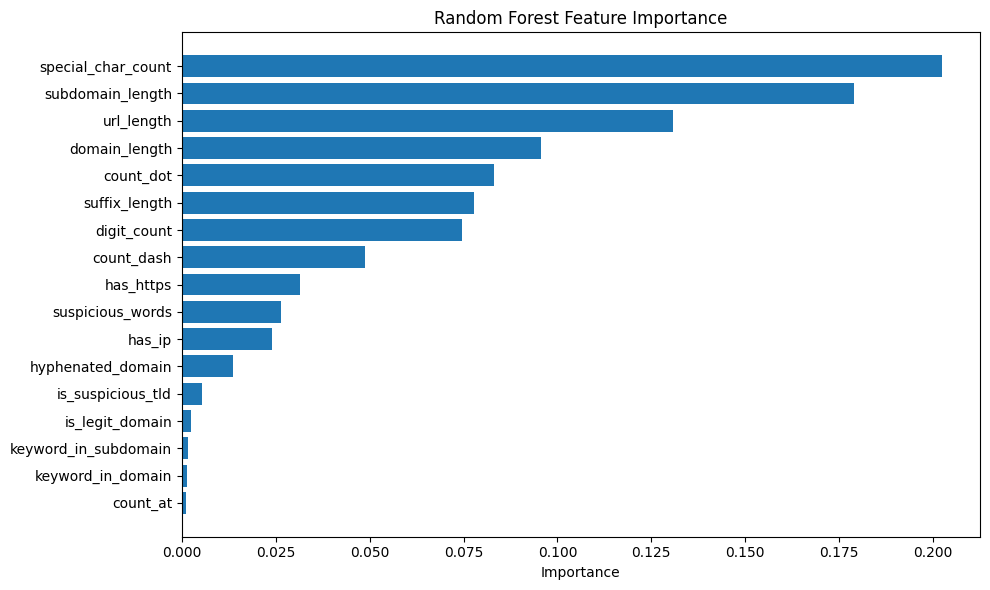

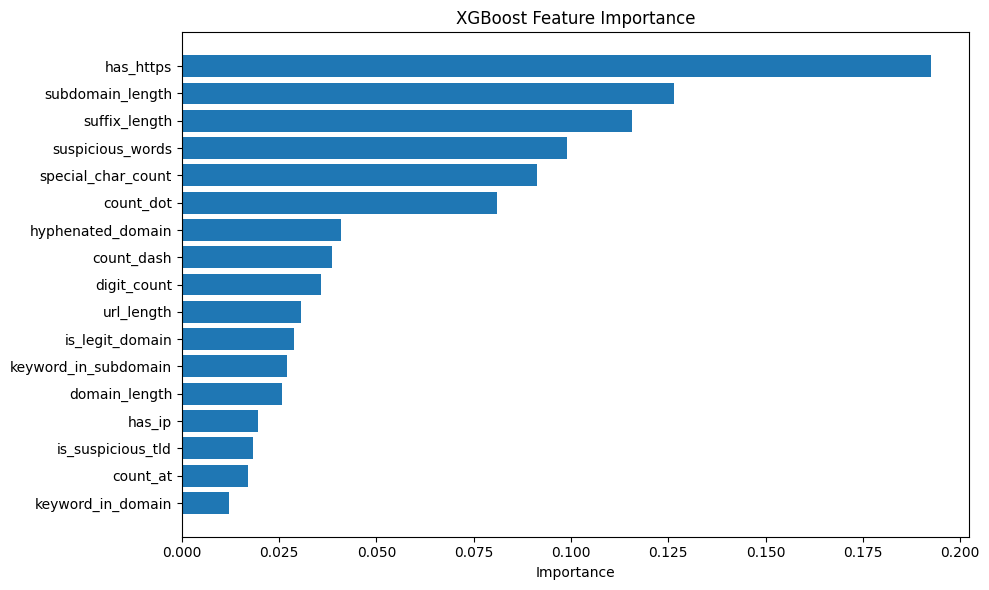

In [94]:

def plot_feature_importance(model, model_name):
    plt.figure(figsize=(10, 6))
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    plt.barh(range(len(importance)), importance[sorted_idx], align='center')
    plt.yticks(range(len(importance)), [X.columns[i] for i in sorted_idx])
    plt.xlabel("Importance")
    plt.title(f"{model_name} Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf_model, "Random Forest")
plot_feature_importance(xgb_model, "XGBoost")

In [99]:

custom_urls = [
    "https://www.google.com/calendar/embed?showTitle=0&height=600&wkst=1&bgcolor=%23FFFFFF&src=qtbqjvhotpcmi2gbkhp15bbh7s@group.calendar.google.com&color=%235C1158&ctz=America/New_York"
]


custom_df = pd.DataFrame([extract_features(url) for url in custom_urls])


custom_preds = label_encoder.inverse_transform(xgb_model.predict(custom_df))


pd.set_option('display.max_colwidth', None)
result_df = pd.DataFrame({
    "URL": custom_urls,
    "Predicted Type": custom_preds
})
print("Predictions on Custom URLs:")
display(result_df)


🔍 Predictions on Custom URLs:


,URL,Predicted Type
0,https://www.google.com/calendar/embed?showTitle=0&height=600&wkst=1&bgcolor=%23FFFFFF&src=qtbqjvhotpcmi2gbkhp15bbh7s@group.calendar.google.com&color=%235C1158&ctz=America/New_York,malware


In [ ]:
import joblib

joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


In [ ]:

joblib.dump(rf_model, 'url_security_model.joblib')